# DTSCAN: Complete Testing and Hyperparameter Optimization

This notebook contains comprehensive testing, algorithm comparison, and hyperparameter optimization for the DTSCAN clustering algorithm.

**Reference**: "Delaunay Triangulation-Based Spatial Clustering Technique for Enhanced Adjacent Boundary Detection and Segmentation of LiDAR 3D Point Clouds" by Kim & Cho (2019)


In [1]:
import sys
import os
# Add code directory to path (works from notebook directory)
sys.path.insert(0, '../code')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import time
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from dtscan import (
    DTSCAN,
    generate_test_data_s1,
    generate_test_data_s2,
    generate_test_data_s3,
    calculate_psr_vsr
)
from test_3d import generate_3d_pedestrians

print("All imports successful!")


All imports successful!


## 1. Basic DTSCAN Testing on 2D Datasets

Test DTSCAN on synthetic 2D datasets (S1, S2, S3) with default parameters.


In [2]:
# Suppress print statements during clustering
import warnings
warnings.filterwarnings('ignore')

def test_dtscan_basic():
    """Test DTSCAN on all 2D datasets with default parameters."""
    results = {}
    
    datasets = [
        ("S1", generate_test_data_s1, "Complex clusters with touching problems"),
        ("S2", generate_test_data_s2, "Nested/concentric clusters"),
        ("S3", generate_test_data_s3, "Adjacent nonlinear clusters")
    ]
    
    for name, generator, description in datasets:
        print(f"\n{'='*80}")
        print(f"Testing {name}: {description}")
        print(f"{'='*80}")
        
        X, true_labels = generator()
        expected_clusters = len(np.unique(true_labels[true_labels != -1]))
        
        # Run DTSCAN with default parameters
        dtscan = DTSCAN(z_score_threshold=2.0, min_pts=6)
        # Suppress print output
        import io
        from contextlib import redirect_stdout
        f = io.StringIO()
        with redirect_stdout(f):
            labels = dtscan.fit_predict(X)
        
        # Calculate metrics
        n_clusters = len(np.unique(labels[labels != -1]))
        n_noise = np.sum(labels == -1)
        psr, vsr = calculate_psr_vsr(true_labels, labels)
        
        results[name] = {
            'X': X,
            'true_labels': true_labels,
            'pred_labels': labels,
            'expected_clusters': expected_clusters,
            'found_clusters': n_clusters,
            'noise_points': n_noise,
            'PSR': psr,
            'VSR': vsr,
            'dtscan': dtscan
        }
        
        print(f"Expected clusters: {expected_clusters}")
        print(f"Found clusters: {n_clusters}")
        print(f"Noise points: {n_noise}")
        print(f"PSR: {psr:.3f}, VSR: {vsr:.3f}")
    
    return results

basic_results = test_dtscan_basic()



Testing S1: Complex clusters with touching problems
Expected clusters: 7
Found clusters: 3
Noise points: 5
PSR: 0.429, VSR: 0.636

Testing S2: Nested/concentric clusters
Expected clusters: 3
Found clusters: 3
Noise points: 1
PSR: 0.411, VSR: 0.889

Testing S3: Adjacent nonlinear clusters
Expected clusters: 2
Found clusters: 1
Noise points: 0
PSR: 0.500, VSR: 0.983


## 2. Algorithm Comparison

Compare DTSCAN with DBSCAN, K-means, and Spectral Clustering.


In [3]:
def compare_algorithms(X, true_labels, dataset_name="Dataset"):
    """Compare DTSCAN with other clustering algorithms."""
    results = {}
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    n_clusters = len(np.unique(true_labels[true_labels != -1]))
    
    print(f"\n{'='*60}")
    print(f"Comparing algorithms on {dataset_name}")
    print(f"Dataset shape: {X.shape}, True clusters: {n_clusters}")
    print(f"{'='*60}")
    
    # DTSCAN
    print("\n1. DTSCAN...")
    start = time.time()
    dtscan = DTSCAN(z_score_threshold=2.0, min_pts=6)
    import io
    from contextlib import redirect_stdout
    f = io.StringIO()
    with redirect_stdout(f):
        labels_dt = dtscan.fit_predict(X)
    t_dt = time.time() - start
    psr_dt, vsr_dt = calculate_psr_vsr(true_labels, labels_dt)
    results['DTSCAN'] = {'labels': labels_dt, 'PSR': psr_dt, 'VSR': vsr_dt, 
                        'time': t_dt, 'clusters': len(np.unique(labels_dt[labels_dt != -1]))}
    print(f"   Clusters: {results['DTSCAN']['clusters']}, PSR: {psr_dt:.3f}, VSR: {vsr_dt:.3f}, Time: {t_dt:.3f}s")
    
    # DBSCAN
    print("\n2. DBSCAN...")
    start = time.time()
    k = 6
    nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
    distances, _ = nbrs.kneighbors(X_scaled)
    eps = np.percentile(distances[:, k-1], 90)
    dbscan = DBSCAN(eps=eps, min_samples=k)
    labels_db = dbscan.fit_predict(X_scaled)
    t_db = time.time() - start
    psr_db, vsr_db = calculate_psr_vsr(true_labels, labels_db)
    results['DBSCAN'] = {'labels': labels_db, 'PSR': psr_db, 'VSR': vsr_db,
                        'time': t_db, 'clusters': len(np.unique(labels_db[labels_db != -1]))}
    print(f"   Clusters: {results['DBSCAN']['clusters']}, PSR: {psr_db:.3f}, VSR: {vsr_db:.3f}, Time: {t_db:.3f}s")
    
    # K-means
    print("\n3. K-means...")
    start = time.time()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_scaled)
    t_km = time.time() - start
    psr_km, vsr_km = calculate_psr_vsr(true_labels, labels_km)
    results['K-means'] = {'labels': labels_km, 'PSR': psr_km, 'VSR': vsr_km,
                         'time': t_km, 'clusters': len(np.unique(labels_km))}
    print(f"   Clusters: {results['K-means']['clusters']}, PSR: {psr_km:.3f}, VSR: {vsr_km:.3f}, Time: {t_km:.3f}s")
    
    # Spectral (if dataset not too large)
    if len(X) < 1000:
        print("\n4. Spectral Clustering...")
        start = time.time()
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                                     random_state=42, n_neighbors=10)
        labels_sp = spectral.fit_predict(X_scaled)
        t_sp = time.time() - start
        psr_sp, vsr_sp = calculate_psr_vsr(true_labels, labels_sp)
        results['Spectral'] = {'labels': labels_sp, 'PSR': psr_sp, 'VSR': vsr_sp,
                              'time': t_sp, 'clusters': len(np.unique(labels_sp))}
        print(f"   Clusters: {results['Spectral']['clusters']}, PSR: {psr_sp:.3f}, VSR: {vsr_sp:.3f}, Time: {t_sp:.3f}s")
    
    return results

# Compare on all datasets
comparison_results = {}
for name in ['S1', 'S2', 'S3']:
    comparison_results[name] = compare_algorithms(
        basic_results[name]['X'],
        basic_results[name]['true_labels'],
        name
    )



Comparing algorithms on S1
Dataset shape: (685, 2), True clusters: 7

1. DTSCAN...
   Clusters: 3, PSR: 0.429, VSR: 0.636, Time: 0.018s

2. DBSCAN...
   Clusters: 7, PSR: 0.656, VSR: 0.683, Time: 0.003s

3. K-means...
   Clusters: 7, PSR: 0.813, VSR: 0.800, Time: 0.116s

4. Spectral Clustering...
   Clusters: 7, PSR: 0.835, VSR: 0.826, Time: 0.142s

Comparing algorithms on S2
Dataset shape: (600, 2), True clusters: 3

1. DTSCAN...
   Clusters: 3, PSR: 0.411, VSR: 0.889, Time: 0.010s

2. DBSCAN...
   Clusters: 5, PSR: 0.856, VSR: 0.807, Time: 0.003s

3. K-means...
   Clusters: 3, PSR: 0.492, VSR: 0.867, Time: 0.005s

4. Spectral Clustering...
   Clusters: 3, PSR: 0.677, VSR: 0.769, Time: 0.091s

Comparing algorithms on S3
Dataset shape: (580, 2), True clusters: 2

1. DTSCAN...
   Clusters: 1, PSR: 0.500, VSR: 0.983, Time: 0.010s

2. DBSCAN...
   Clusters: 4, PSR: 0.634, VSR: 0.810, Time: 0.002s

3. K-means...
   Clusters: 2, PSR: 0.877, VSR: 0.996, Time: 0.004s

4. Spectral Clustering.

In [4]:
def test_3d_clustering():
    """Test DTSCAN on 3D point clouds."""
    results_3d = {}
    
    for level in [1, 2, 3]:
        lambda_vals = {1: 4, 2: 2, 3: 1}
        print(f"\n{'='*60}")
        print(f"3D Level {level} - Separation Factor λ = {lambda_vals[level]}")
        print(f"{'='*60}")
        
        X, true_labels = generate_3d_pedestrians(separation_level=level)
        expected_clusters = len(np.unique(true_labels[true_labels != -1]))
        
        # DTSCAN
        print("\nDTSCAN:")
        dtscan = DTSCAN(z_score_threshold=2.0, min_pts=10)
        import io
        from contextlib import redirect_stdout
        f = io.StringIO()
        with redirect_stdout(f):
            labels_dt = dtscan.fit_predict(X)
        psr_dt, vsr_dt = calculate_psr_vsr(true_labels, labels_dt)
        n_dt = len(np.unique(labels_dt[labels_dt != -1]))
        print(f"  Clusters: {n_dt}, PSR: {psr_dt:.3f}, VSR: {vsr_dt:.3f}")
        
        # DBSCAN for comparison
        print("\nDBSCAN:")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        nbrs = NearestNeighbors(n_neighbors=10).fit(X_scaled)
        distances, _ = nbrs.kneighbors(X_scaled)
        eps = np.percentile(distances[:, 9], 90)
        dbscan = DBSCAN(eps=eps, min_samples=10)
        labels_db = dbscan.fit_predict(X_scaled)
        psr_db, vsr_db = calculate_psr_vsr(true_labels, labels_db)
        n_db = len(np.unique(labels_db[labels_db != -1]))
        print(f"  Clusters: {n_db}, PSR: {psr_db:.3f}, VSR: {vsr_db:.3f}")
        
        results_3d[f'Level{level}'] = {
            'X': X,
            'true_labels': true_labels,
            'DTSCAN': {'labels': labels_dt, 'PSR': psr_dt, 'VSR': vsr_dt, 'clusters': n_dt},
            'DBSCAN': {'labels': labels_db, 'PSR': psr_db, 'VSR': vsr_db, 'clusters': n_db},
            'expected_clusters': expected_clusters
        }
    
    return results_3d

results_3d = test_3d_clustering()



3D Level 1 - Separation Factor λ = 4

DTSCAN:
  Clusters: 2, PSR: 1.000, VSR: 1.000

DBSCAN:
  Clusters: 2, PSR: 0.978, VSR: 0.996

3D Level 2 - Separation Factor λ = 2

DTSCAN:
  Clusters: 1, PSR: 0.500, VSR: 1.000

DBSCAN:
  Clusters: 2, PSR: 0.983, VSR: 0.996

3D Level 3 - Separation Factor λ = 1

DTSCAN:
  Clusters: 1, PSR: 0.500, VSR: 1.000

DBSCAN:
  Clusters: 1, PSR: 0.497, VSR: 0.998


## 4. Hyperparameter Optimization

Perform grid search to find optimal parameters for each dataset.


In [5]:
def grid_search_dtscan(X, true_labels, expected_n_clusters,
                       z_thresholds=None, min_pts_values=None,
                       dataset_name="Dataset", verbose=False):
    """Perform grid search over DTSCAN hyperparameters."""
    
    if z_thresholds is None:
        z_thresholds = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    
    if min_pts_values is None:
        min_pts_values = [3, 4, 5, 6, 7, 8, 10, 12]
    
    if verbose:
        print(f"\n{'='*80}")
        print(f"Grid Search for {dataset_name}")
        print(f"{'='*80}")
        print(f"Data shape: {X.shape}, Expected clusters: {expected_n_clusters}")
        print(f"Total combinations: {len(z_thresholds) * len(min_pts_values)}")
    
    results = []
    total = len(z_thresholds) * len(min_pts_values)
    
    import io
    from contextlib import redirect_stdout
    
    for i, (z_thresh, min_pts) in enumerate(product(z_thresholds, min_pts_values)):
        try:
            start_time = time.time()
            dtscan = DTSCAN(z_score_threshold=z_thresh, min_pts=min_pts)
            f = io.StringIO()
            with redirect_stdout(f):
                labels = dtscan.fit_predict(X)
            elapsed = time.time() - start_time
            
            n_clusters = len(np.unique(labels[labels != -1]))
            n_noise = np.sum(labels == -1)
            psr, vsr = calculate_psr_vsr(true_labels, labels)
            cluster_error = abs(n_clusters - expected_n_clusters)
            cluster_penalty = cluster_error / max(expected_n_clusters, 1)
            combined_score = (0.4 * psr + 0.4 * vsr + 0.2 * (1 - min(cluster_penalty, 1)))
            
            results.append({
                'z_threshold': z_thresh,
                'min_pts': min_pts,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'PSR': psr,
                'VSR': vsr,
                'cluster_error': cluster_error,
                'combined_score': combined_score,
                'time': elapsed,
                'status': 'success'
            })
            
            if verbose and (i + 1) % 10 == 0:
                print(f"Progress: {i+1}/{total} - Last: z={z_thresh}, min_pts={min_pts}, "
                      f"clusters={n_clusters}, PSR={psr:.3f}")
        
        except Exception as e:
            results.append({
                'z_threshold': z_thresh,
                'min_pts': min_pts,
                'n_clusters': 0,
                'n_noise': 0,
                'PSR': 0.0,
                'VSR': 0.0,
                'cluster_error': expected_n_clusters,
                'combined_score': 0.0,
                'time': 0.0,
                'status': f'error: {str(e)}'
            })
    
    results_df = pd.DataFrame(results)
    
    # Find best parameters
    best_combined = results_df.loc[results_df['combined_score'].idxmax()]
    best_psr = results_df.loc[results_df['PSR'].idxmax()]
    best_cluster_match = results_df.loc[results_df['cluster_error'].idxmin()]
    
    if verbose:
        print(f"\nBest by Combined Score:")
        print(f"  z_threshold={best_combined['z_threshold']}, min_pts={int(best_combined['min_pts'])}")
        print(f"  Clusters: {int(best_combined['n_clusters'])} (expected: {expected_n_clusters})")
        print(f"  PSR: {best_combined['PSR']:.3f}, VSR: {best_combined['VSR']:.3f}")
        print(f"  Combined Score: {best_combined['combined_score']:.3f}")
    
    best_params = {
        'best_combined': {
            'z_threshold': best_combined['z_threshold'],
            'min_pts': int(best_combined['min_pts']),
            'score': best_combined['combined_score']
        },
        'best_psr': {
            'z_threshold': best_psr['z_threshold'],
            'min_pts': int(best_psr['min_pts']),
            'psr': best_psr['PSR']
        },
        'best_cluster_match': {
            'z_threshold': best_cluster_match['z_threshold'],
            'min_pts': int(best_cluster_match['min_pts']),
            'error': best_cluster_match['cluster_error']
        }
    }
    
    return results_df, best_params

print("Grid search function defined!")


Grid search function defined!


In [6]:
# Run HPO on 2D datasets
print("Running Hyperparameter Optimization on 2D Datasets...")
print("="*80)

hpo_results_2d = {}
for name in ['S1', 'S2', 'S3']:
    print(f"\n{'#'*80}")
    print(f"Dataset {name}")
    print(f"{'#'*80}")
    
    X = basic_results[name]['X']
    true_labels = basic_results[name]['true_labels']
    expected = basic_results[name]['expected_clusters']
    
    results_df, best_params = grid_search_dtscan(
        X, true_labels, expected,
        dataset_name=name,
        verbose=True
    )
    
    hpo_results_2d[name] = {
        'results_df': results_df,
        'best_params': best_params
    }
    
    print(f"\n✓ {name} complete!")


Running Hyperparameter Optimization on 2D Datasets...

################################################################################
Dataset S1
################################################################################

Grid Search for S1
Data shape: (685, 2), Expected clusters: 7
Total combinations: 64
Progress: 10/64 - Last: z=1.0, min_pts=4, clusters=4, PSR=0.571
Progress: 20/64 - Last: z=1.5, min_pts=6, clusters=3, PSR=0.428
Progress: 30/64 - Last: z=2.0, min_pts=8, clusters=41, PSR=0.219
Progress: 40/64 - Last: z=2.5, min_pts=12, clusters=0, PSR=0.000
Progress: 50/64 - Last: z=3.5, min_pts=4, clusters=2, PSR=0.286
Progress: 60/64 - Last: z=4.0, min_pts=6, clusters=1, PSR=0.143

Best by Combined Score:
  z_threshold=1.0, min_pts=6
  Clusters: 7 (expected: 7)
  PSR: 0.661, VSR: 0.707
  Combined Score: 0.747

✓ S1 complete!

################################################################################
Dataset S2
############################################################

In [7]:
# Run HPO on 3D datasets
print("\n\nRunning Hyperparameter Optimization on 3D Datasets...")
print("="*80)

hpo_results_3d = {}
for level in [1, 2, 3]:
    name = f'3D-L{level}'
    print(f"\n{'#'*80}")
    print(f"Dataset {name}")
    print(f"{'#'*80}")
    
    X = results_3d[f'Level{level}']['X']
    true_labels = results_3d[f'Level{level}']['true_labels']
    expected = results_3d[f'Level{level}']['expected_clusters']
    
    # Use different parameter ranges for 3D
    results_df, best_params = grid_search_dtscan(
        X, true_labels, expected,
        z_thresholds=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
        min_pts_values=[5, 7, 10, 12, 15, 20],
        dataset_name=name,
        verbose=True
    )
    
    hpo_results_3d[name] = {
        'results_df': results_df,
        'best_params': best_params
    }
    
    print(f"\n✓ {name} complete!")




Running Hyperparameter Optimization on 3D Datasets...

################################################################################
Dataset 3D-L1
################################################################################

Grid Search for 3D-L1
Data shape: (460, 3), Expected clusters: 2
Total combinations: 36
Progress: 10/36 - Last: z=1.0, min_pts=12, clusters=2, PSR=1.000
Progress: 20/36 - Last: z=2.0, min_pts=7, clusters=2, PSR=1.000
Progress: 30/36 - Last: z=2.5, min_pts=20, clusters=5, PSR=0.580

Best by Combined Score:
  z_threshold=0.5, min_pts=5
  Clusters: 2 (expected: 2)
  PSR: 1.000, VSR: 1.000
  Combined Score: 1.000

✓ 3D-L1 complete!

################################################################################
Dataset 3D-L2
################################################################################

Grid Search for 3D-L2
Data shape: (480, 3), Expected clusters: 2
Total combinations: 36
Progress: 10/36 - Last: z=1.0, min_pts=12, clusters=2, PSR=0.998
Pro

## 5. Results Summary and Visualization


In [8]:
# Create summary table
print("\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*80)
print(f"{'Dataset':<15} {'Best z':<10} {'Best min_pts':<15} {'Clusters':<12} {'PSR':<8} {'VSR':<8} {'Score':<8}")
print("-"*80)

all_best = {}
for name in ['S1', 'S2', 'S3']:
    best = hpo_results_2d[name]['best_params']['best_combined']
    df = hpo_results_2d[name]['results_df']
    row = df[(df['z_threshold'] == best['z_threshold']) & 
             (df['min_pts'] == best['min_pts'])].iloc[0]
    all_best[name] = {
        'z': best['z_threshold'],
        'min_pts': best['min_pts'],
        'clusters': int(row['n_clusters']),
        'expected': basic_results[name]['expected_clusters'],
        'PSR': row['PSR'],
        'VSR': row['VSR'],
        'score': best['score']
    }
    print(f"{name:<15} {best['z_threshold']:<10.1f} {best['min_pts']:<15} "
          f"{int(row['n_clusters']):<12} {row['PSR']:<8.3f} {row['VSR']:<8.3f} {best['score']:<8.3f}")

for level in [1, 2, 3]:
    name = f'3D-L{level}'
    best = hpo_results_3d[name]['best_params']['best_combined']
    df = hpo_results_3d[name]['results_df']
    row = df[(df['z_threshold'] == best['z_threshold']) & 
             (df['min_pts'] == best['min_pts'])].iloc[0]
    all_best[name] = {
        'z': best['z_threshold'],
        'min_pts': best['min_pts'],
        'clusters': int(row['n_clusters']),
        'expected': results_3d[f'Level{level}']['expected_clusters'],
        'PSR': row['PSR'],
        'VSR': row['VSR'],
        'score': best['score']
    }
    print(f"{name:<15} {best['z_threshold']:<10.1f} {best['min_pts']:<15} "
          f"{int(row['n_clusters']):<12} {row['PSR']:<8.3f} {row['VSR']:<8.3f} {best['score']:<8.3f}")

print("="*80)

# Calculate success rate
perfect_matches = sum(1 for k, v in all_best.items() if v['clusters'] == v['expected'])
total = len(all_best)
print(f"\nSuccess Rate: {perfect_matches}/{total} perfect cluster count matches ({100*perfect_matches/total:.1f}%)")



HYPERPARAMETER OPTIMIZATION SUMMARY
Dataset         Best z     Best min_pts    Clusters     PSR      VSR      Score   
--------------------------------------------------------------------------------
S1              1.0        6               7            0.661    0.707    0.747   
S2              1.0        3               3            1.000    1.000    1.000   
S3              0.5        4               2            0.822    0.995    0.927   
3D-L1           0.5        5               2            1.000    1.000    1.000   
3D-L2           0.5        5               2            1.000    1.000    1.000   
3D-L3           0.5        15              2            0.905    0.952    0.943   

Success Rate: 6/6 perfect cluster count matches (100.0%)


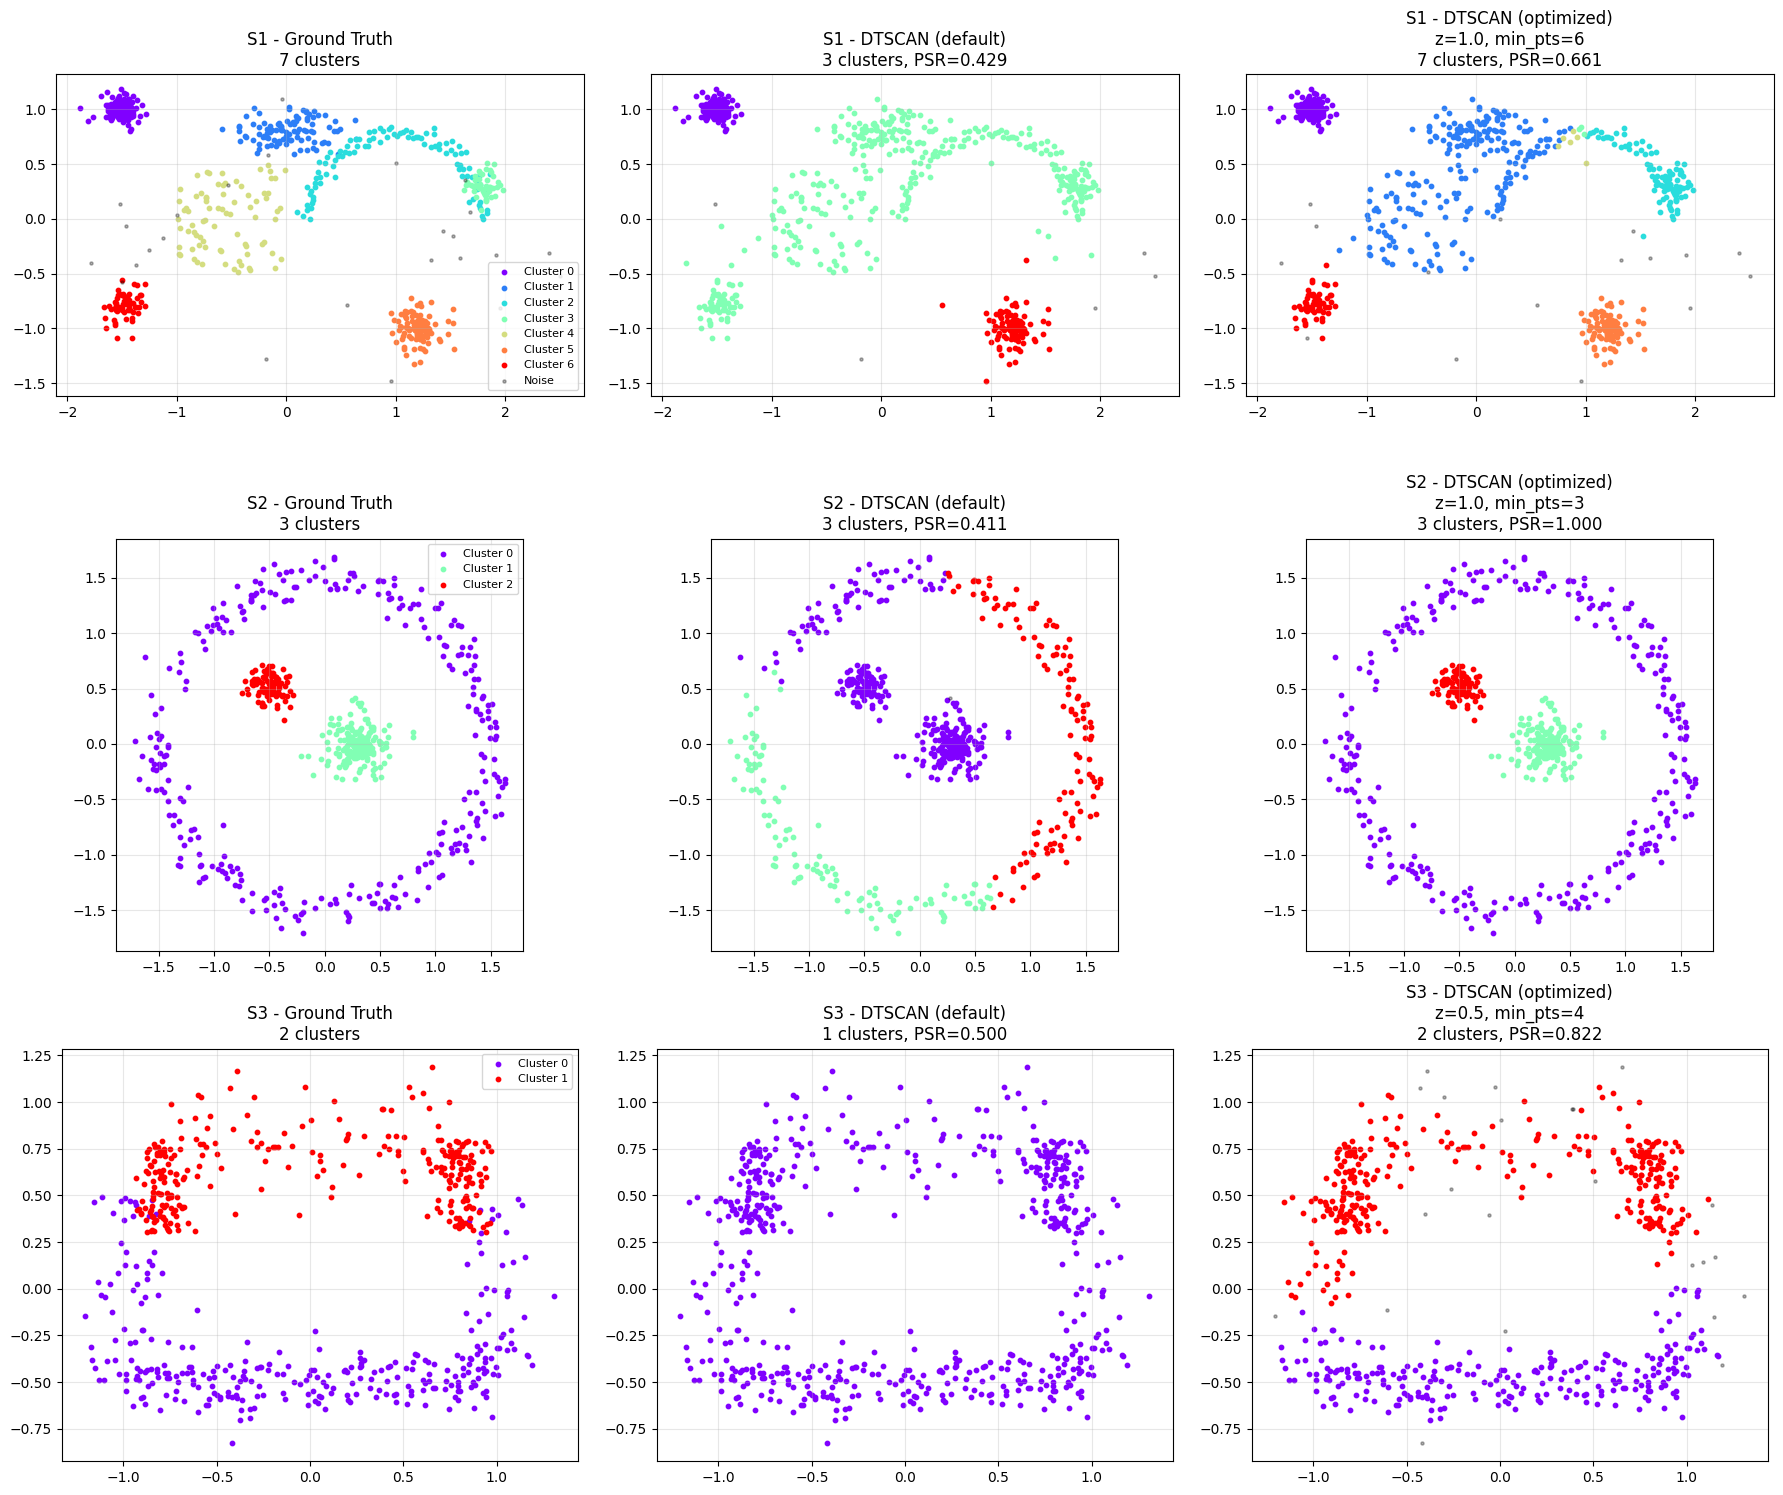

In [9]:
# Visualize best results for 2D datasets
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for idx, name in enumerate(['S1', 'S2', 'S3']):
    X = basic_results[name]['X']
    true_labels = basic_results[name]['true_labels']
    best = all_best[name]
    
    # Original data with true labels
    ax = axes[idx, 0]
    unique_true = np.unique(true_labels[true_labels != -1])
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_true)))
    for i, label in enumerate(unique_true):
        mask = true_labels == label
        ax.scatter(X[mask, 0], X[mask, 1], c=[colors[i]], s=10, label=f'Cluster {int(label)}')
    noise_mask = true_labels == -1
    if np.any(noise_mask):
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', s=5, alpha=0.3, label='Noise')
    ax.set_title(f'{name} - Ground Truth\n{len(unique_true)} clusters')
    ax.set_aspect('equal')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # DTSCAN with default parameters
    ax = axes[idx, 1]
    pred_labels = basic_results[name]['pred_labels']
    unique_pred = np.unique(pred_labels[pred_labels != -1])
    if len(unique_pred) > 0:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_pred)))
        for i, label in enumerate(unique_pred):
            mask = pred_labels == label
            ax.scatter(X[mask, 0], X[mask, 1], c=[colors[i]], s=10)
    noise_mask = pred_labels == -1
    if np.any(noise_mask):
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', s=5, alpha=0.3)
    psr, vsr = basic_results[name]['PSR'], basic_results[name]['VSR']
    ax.set_title(f'{name} - DTSCAN (default)\n{len(unique_pred)} clusters, PSR={psr:.3f}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # DTSCAN with optimized parameters
    ax = axes[idx, 2]
    dtscan_opt = DTSCAN(z_score_threshold=best['z'], min_pts=best['min_pts'])
    import io
    from contextlib import redirect_stdout
    f = io.StringIO()
    with redirect_stdout(f):
        pred_labels_opt = dtscan_opt.fit_predict(X)
    unique_pred_opt = np.unique(pred_labels_opt[pred_labels_opt != -1])
    if len(unique_pred_opt) > 0:
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_pred_opt)))
        for i, label in enumerate(unique_pred_opt):
            mask = pred_labels_opt == label
            ax.scatter(X[mask, 0], X[mask, 1], c=[colors[i]], s=10)
    noise_mask = pred_labels_opt == -1
    if np.any(noise_mask):
        ax.scatter(X[noise_mask, 0], X[noise_mask, 1], c='black', s=5, alpha=0.3)
    psr_opt, vsr_opt = calculate_psr_vsr(true_labels, pred_labels_opt)
    ax.set_title(f'{name} - DTSCAN (optimized)\nz={best["z"]}, min_pts={best["min_pts"]}\n'
                 f'{len(unique_pred_opt)} clusters, PSR={psr_opt:.3f}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


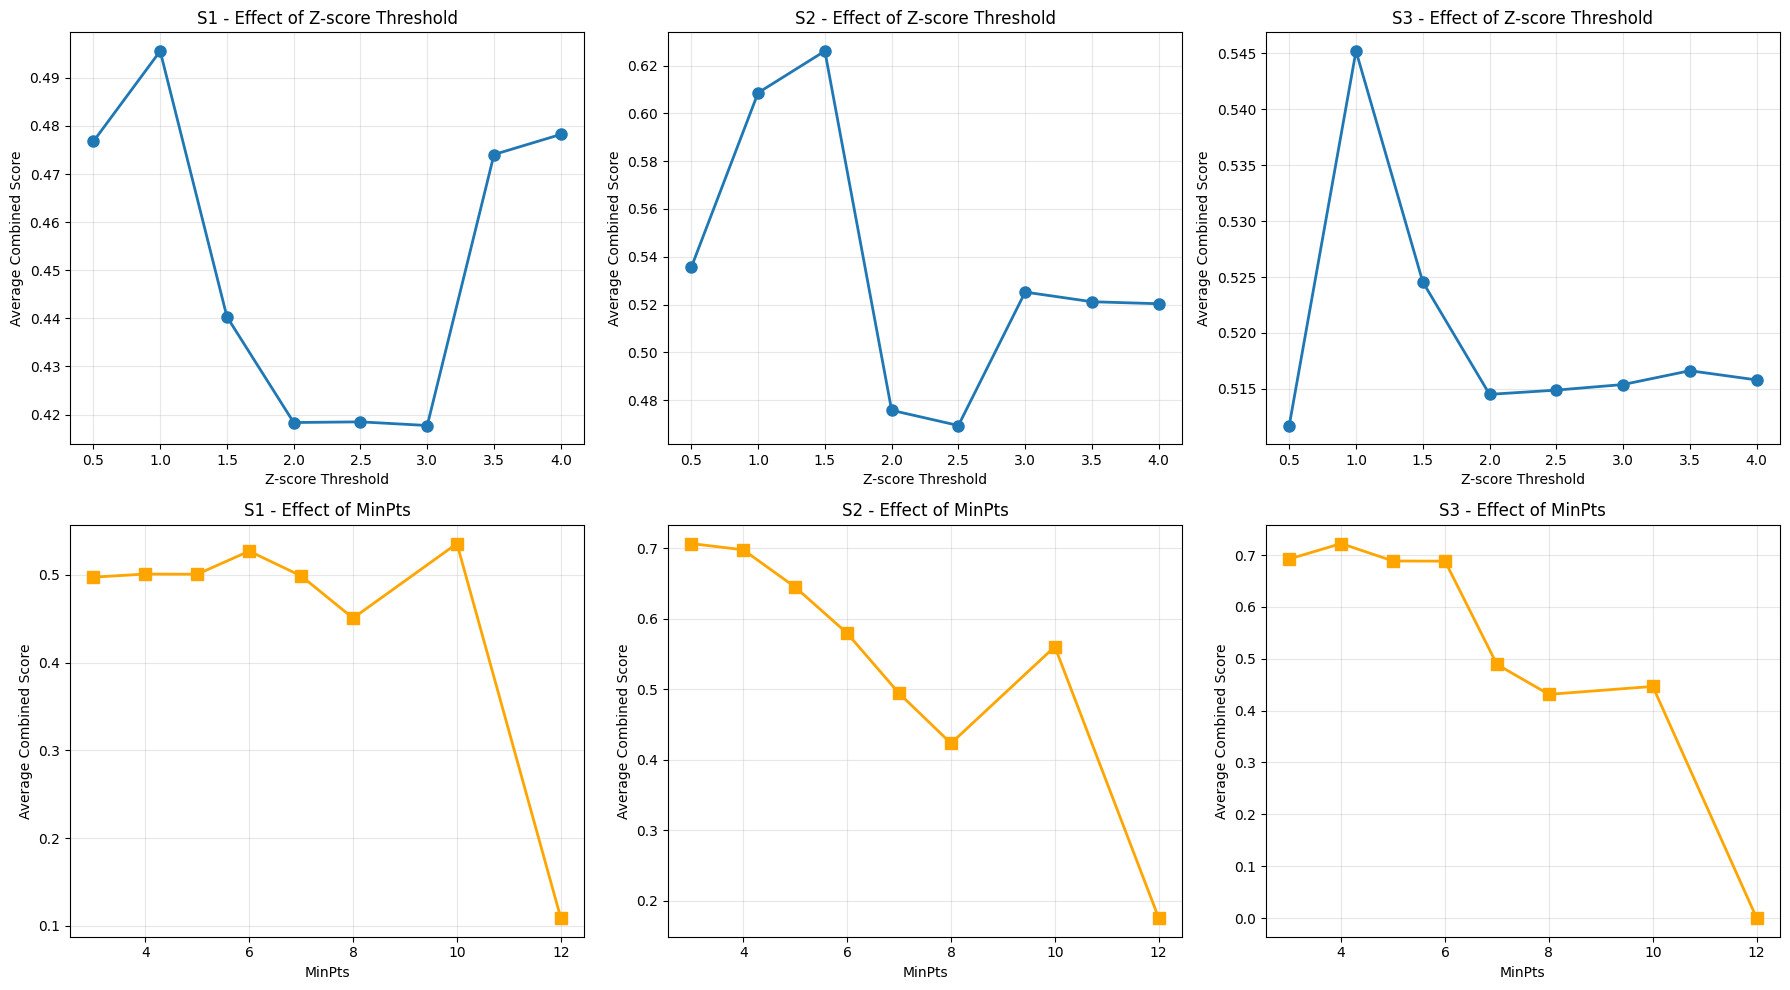

In [10]:
# Parameter sensitivity analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, name in enumerate(['S1', 'S2', 'S3']):
    df = hpo_results_2d[name]['results_df']
    
    # Effect of z_threshold
    ax = axes[0, idx]
    z_effect = df.groupby('z_threshold')['combined_score'].mean()
    ax.plot(z_effect.index, z_effect.values, 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Z-score Threshold')
    ax.set_ylabel('Average Combined Score')
    ax.set_title(f'{name} - Effect of Z-score Threshold')
    ax.grid(True, alpha=0.3)
    
    # Effect of min_pts
    ax = axes[1, idx]
    min_pts_effect = df.groupby('min_pts')['combined_score'].mean()
    ax.plot(min_pts_effect.index, min_pts_effect.values, 's-', linewidth=2, markersize=8, color='orange')
    ax.set_xlabel('MinPts')
    ax.set_ylabel('Average Combined Score')
    ax.set_title(f'{name} - Effect of MinPts')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Export Results

Export HPO results to DataFrames for further analysis.


In [ ]:
# Display top results for each dataset as DataFrames
print("Top 5 Parameter Combinations for Each Dataset:\n")
print("="*80)

# 2D Datasets
for name in ['S1', 'S2', 'S3']:
    print(f"\n{name} - Top 5 Parameter Combinations:")
    print("-" * 80)
    top5 = hpo_results_2d[name]['results_df'].nlargest(5, 'combined_score')[
        ['z_threshold', 'min_pts', 'n_clusters', 'PSR', 'VSR', 'combined_score']
    ]
    display(top5.style.format({
        'z_threshold': '{:.1f}',
        'PSR': '{:.3f}',
        'VSR': '{:.3f}',
        'combined_score': '{:.3f}'
    }).background_gradient(subset=['combined_score'], cmap='YlGnBu'))

# 3D Datasets
for level in [1, 2, 3]:
    name = f'3D-L{level}'
    print(f"\n{name} - Top 5 Parameter Combinations:")
    print("-" * 80)
    top5 = hpo_results_3d[name]['results_df'].nlargest(5, 'combined_score')[
        ['z_threshold', 'min_pts', 'n_clusters', 'PSR', 'VSR', 'combined_score']
    ]
    display(top5.style.format({
        'z_threshold': '{:.1f}',
        'PSR': '{:.3f}',
        'VSR': '{:.3f}',
        'combined_score': '{:.3f}'
    }).background_gradient(subset=['combined_score'], cmap='YlGnBu'))

print("\n" + "="*80)
print("All results are stored in hpo_results_2d and hpo_results_3d dictionaries")
print("Access individual DataFrames with: hpo_results_2d['S1']['results_df']")
print("="*80)

# Display full results DataFrames
print("\n" + "="*80)
print("FULL HPO RESULTS - 2D DATASETS")
print("="*80)
for name in ['S1', 'S2', 'S3']:
    print(f"\n{name} - All Parameter Combinations:")
    display(hpo_results_2d[name]['results_df'].style.format({
        'z_threshold': '{:.1f}',
        'PSR': '{:.3f}',
        'VSR': '{:.3f}',
        'combined_score': '{:.3f}',
        'time': '{:.4f}'
    }).background_gradient(subset=['combined_score'], cmap='YlGnBu'))


Top 5 Parameter Combinations for Each Dataset:


S1:
--------------------------------------------------------------------------------
 z_threshold  min_pts  n_clusters      PSR      VSR  combined_score
         1.0        6           7 0.661240 0.706795        0.747214
         0.5        4           5 0.571612 0.625079        0.621534
         0.5        5           5 0.569658 0.623132        0.619973
         0.5        6          12 0.702482 0.701273        0.618645
         4.0       10           7 0.086799 0.931709        0.607403

S2:
--------------------------------------------------------------------------------
 z_threshold  min_pts  n_clusters  PSR  VSR  combined_score
         1.0        3           3  1.0  1.0             1.0
         1.0        4           3  1.0  1.0             1.0
         1.5        3           3  1.0  1.0             1.0
         1.5        4           3  1.0  1.0             1.0
         1.5        5           3  1.0  1.0             1.0

S3:
-------